# Monte Carlo Simulation by RocketPy - EuroC 2022

## Import Libraries

In [1]:
import glob
import math 
import traceback
import warnings
from datetime import datetime
from time import perf_counter, process_time, time

import jsonpickle
import matplotlib.pyplot as plt
import numpy as np
import simplekml
from imageio import imread
from IPython.display import display
from matplotlib.patches import Ellipse
from numpy.random import choice, normal, uniform
from rocketpy import Environment, Flight, Function, Rocket, SolidMotor

from support import *


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%config InlineBackend.figure_formats = ['svg']
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline

## Define auxiliary functions

In [4]:
def export_flight_data(flight_setting, flight_data, exec_time):
    # Generate flight results
    flight_result = {
        "outOfRailTime": flight_data.outOfRailTime,
        "outOfRailVelocity": flight_data.outOfRailVelocity,
        "apogeeTime": flight_data.apogeeTime,
        "apogeeAltitude": flight_data.apogee - flight_data.env.elevation,
        "apogeeX": flight_data.apogeeX,
        "apogeeY": flight_data.apogeeY,
        "impactTime": flight_data.tFinal,
        "impactX": flight_data.xImpact,
        "impactY": flight_data.yImpact,
        "impactVelocity": flight_data.impactVelocity,
        "initialStaticMargin": flight_data.rocket.staticMargin(0),
        "outOfRailStaticMargin": flight_data.rocket.staticMargin(
            flight_data.outOfRailTime
        ),
        "finalStaticMargin": flight_data.rocket.staticMargin(
            flight_data.rocket.motor.burnOutTime
        ),
        "numberOfEvents": len(flight_data.parachuteEvents),
        "executionTime": exec_time,
    }

    # Calculate maximum reached velocity
    sol = np.array(flight_data.solution)
    flight_data.vx = Function(
        sol[:, [0, 4]], "Time (s)", "Vx (m/s)", "linear", extrapolation="natural"
    )
    flight_data.vy = Function(
        sol[:, [0, 5]], "Time (s)", "Vy (m/s)", "linear", extrapolation="natural"
    )
    flight_data.vz = Function(
        sol[:, [0, 6]], "Time (s)", "Vz (m/s)", "linear", extrapolation="natural"
    )
    flight_data.v = (
        flight_data.vx**2 + flight_data.vy**2 + flight_data.vz**2
    ) ** 0.5
    flight_data.maxVel = np.amax(flight_data.v.source[:, 1])
    flight_result["maxVelocity"] = flight_data.maxVel

    # Take care of parachute results
    if len(flight_data.parachuteEvents) > 0:
        flight_result["drogueTriggerTime"] = flight_data.parachuteEvents[0][0]
        flight_result["drogueInflatedTime"] = (
            flight_data.parachuteEvents[0][0] + flight_data.parachuteEvents[0][1].lag
        )
        flight_result["drogueInflatedVelocity"] = flight_data.v(
            flight_data.parachuteEvents[0][0] + flight_data.parachuteEvents[0][1].lag
        )
    else:
        flight_result["drogueTriggerTime"] = 0
        flight_result["drogueInflatedTime"] = 0
        flight_result["drogueInflatedVelocity"] = 0

    # Write flight setting and results to file
    dispersion_input_file.write(str(flight_setting) + "\n")
    dispersion_output_file.write(str(flight_result) + "\n")


def export_flight_error(flight_setting):
    dispersion_error_file.write(str(flight_setting) + "\n")


## Load parameters

In [5]:
analysis_parameters = {
    # Mass Details
    "rocketMass": (
        51.5515,
        0.001,
    ),  # Rocket's dry mass (kg) and its uncertainty (standard deviation)
    # Propulsion Details - run help(SolidMotor) for more information
    "impulse": (17645.766, 50),  # Motor total impulse (N*s)
    "burnOut": (4.3512, 0.5),  # Motor burn out time (s)
    "nozzleRadius": (0.03675, 0),  # Motor's nozzle radius (m)
    "throatRadius": (0.0245, 0),  # Motor's nozzle throat radius (m)
    "grainSeparation": (
        0,
        0,
    ),  # Motor's grain separation (axial distance between two grains) (m)
    "grainDensity": (1281.99, 0),  # Motor's grain density (kg/m^3)
    "grainOuterRadius": (0.049, 0),  # Motor's grain outer radius (m)
    "grainInitialInnerRadius": (
        0.0245,
        0,
    ),  # Motor's grain inner radius (m)
    "grainInitialHeight": (1.293, 0),  # Motor's grain height (m)
    # Aerodynamic Details - run help(Rocket) for more information
    "inertiaI": (
        83.941,
        0,
    ),  # Rocket's inertia moment perpendicular to its axis (kg*m^2)
    "inertiaZ": (
        0.34261,
        0,
    ),  # Rocket's inertia moment relative to its axis (kg*m^2)
    "radius": (0.0895, 0.001),  # Rocket's radius (kg*m^2)
    "distanceRocketNozzle": (
        -1.863900,
        0.001,
    ),  # Distance between rocket's center of dry mass and nozzle exit plane (m) (negative)
    "distanceRocketPropellant": (
        -1.1318402346041072,
        0.001,
    ),  # Distance between rocket's center of dry mass and and center of propellant mass (m) (negative)
    "powerOffDrag": (
        1,
        0.033,
    ),  # Multiplier for rocket's drag curve. Usually has a mean value of 1 and a uncertainty of 5% to 10%
    "powerOnDrag": (
        1,
        0.033,
    ),  # Multiplier for rocket's drag curve. Usually has a mean value of 1 and a uncertainty of 5% to 10%
    "noseLength": (0.745, 0),  # Rocket's nose cone length (m)
    "noseDistanceToCM": (
        1.4640999999999997,
        0.001,
    ),  # Axial distance between rocket's center of dry mass and nearest point in its nose cone (m)
    "finSpan": (0.147, 0),  # Fin span (m)
    "finRootChord": (0.625, 0),  # Fin root chord (m)
    "finTipChord": (0.354, 0),  # Fin tip chord (m)
    "finDistanceToCM": (
        -1.0989000000000009,
        0.001,
    ),  # Axial distance between rocket's center of dry mass and nearest point in its fin (m)
    # Launch and Environment Details - run help(Environment) and help(Flight) for more information
    "inclination": (
        84,
        1,
    ),  # Launch rail inclination angle relative to the horizontal plane (degrees)
    "heading": (133, 2),  # Launch rail heading relative to north (degrees)
    "railLength": (5.2, 0),  # Launch rail length (m)
    "ensembleMember": list(range(20)),  # Members of the ensemble forecast to be used
    # Parachute Details - run help(Rocket) for more information
    # "CdSMain": (
    #     0.349 * 1.3,
    #     0.05,
    # ),  # Drag coefficient times reference area for the drogue chute
    # "CdSDrogue": (
    #     0.349 * 1.3,
    #     0.05,
    # ),  # Drag coefficient times reference area for the drogue chute (m^2)
    # "lag_rec": (
    #     1,
    #     0.5,
    # ),  # Time delay between parachute ejection signal is detected and parachute is inflated (s)
    # # Electronic Systems Details - run help(Rocket) for more information
    # "lag_se": (
    #     0.73,
    #     0.16,
    # ),  # Time delay between sensor signal is received and ejection signal is fired (s)
}


## Run simulations

In [6]:
Env = Environment(railLength=5.2, date=datetime(2022, 10, 16, 12))
Env.setLocation(39.389662, -8.288959)
Env.setElevation(113)

Env.setAtmosphericModel(type="Ensemble", file="GEFS")


oc_open: server error retrieving url: code=0 message="/gens_bc/gens20221011/gep_all_18z is not an available dataset"

Gravity Details

Acceleration of Gravity: 9.80665 m/s²


Launch Site Details

Launch Rail Length: 5.2  m
Launch Date: 2022-10-16 12:00:00 UTC
Launch Site Latitude: 39.38966°
Launch Site Longitude: -8.28896°
Launch Site Surface Elevation: 113.0 m


Atmospheric Model Details

Atmospheric Model Type: Ensemble
Ensemble Maximum Height: 31.157 km
Ensemble Time Period: From  2022-10-11 12:00:00  to  2022-10-27 12:00:00  UTC
Ensemble Hour Interval: 6  hrs
Ensemble Latitude Range: From  -90.0 ° To  90.0 °
Ensemble Longitude Range: From  0.0 ° To  359.5 °
Number of Ensemble Members: 21
Selected Ensemble Member: 0  (Starts from 0)


Surface Atmospheric Conditions

Surface Wind Speed: 1.88 m/s
Surface Wind Direction: 146.14°
Surface Wind Heading: 326.14°
Surface Pressure: 1000.00 hPa
Surface Temperature: 297.99 K
Surface Air Density: 1.169 kg/m³
Surface Speed of Sound: 346.06 m/s


Atmospheric Model Plots


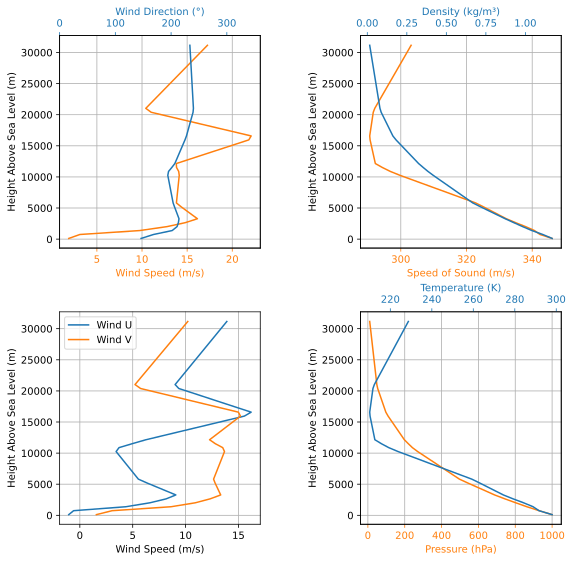



Ensemble Members Comparison


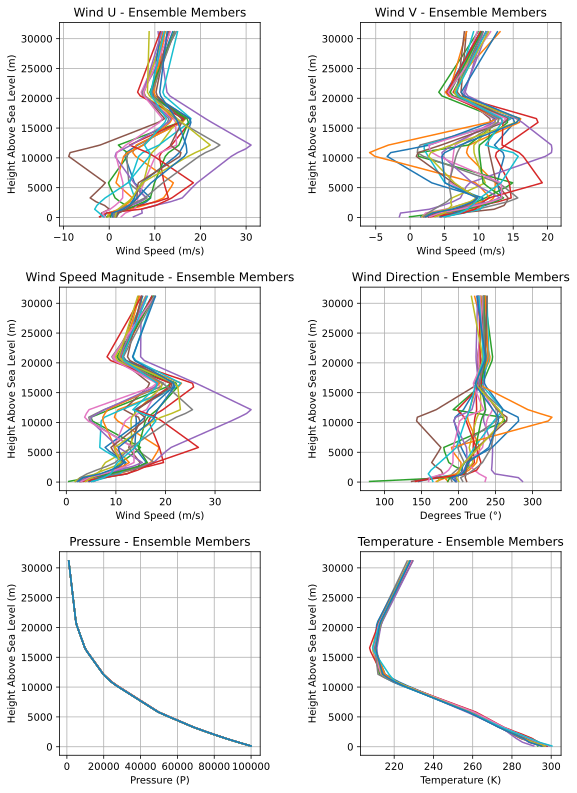

In [7]:
Env.allInfo()


In [8]:
# Basic analysis info
filename = "dispersion_analysis/team_02_ballistic"
number_of_simulations = 2

# Create data files for inputs, outputs and error logging
dispersion_error_file = open(str(filename) + ".disp_errors.txt", "a")
dispersion_input_file = open(str(filename) + ".disp_inputs.txt", "a")
dispersion_output_file = open(str(filename) + ".disp_outputs.txt", "a")


In [9]:
# Initialize counter and timer
i = 0

initial_wall_time = time()
initial_cpu_time = process_time()

# # Set up parachutes. This rocket, named Valetudo, only has a drogue chute.
# def drogueTrigger(p, y):
#     # Check if rocket is going down, i.e. if it has passed the apogee
#     vertical_velocity = y[5]
#     # Return true to activate parachute once the vertical velocity is negative
#     return True if vertical_velocity < 0 else False


# def mainTrigger(p, y):
#     # Check if rocket is going down, i.e. if it has passed the apogee
#     vertical_velocity = y[5]
#     # Return true to activate parachute once the vertical velocity is negative
#     return True if vertical_velocity < 0 and y[2] < 150 + 450 else False  # HARDCODED


# Iterate over flight settings
out = display("Starting", display_id=True)
for setting in flight_settings(analysis_parameters, number_of_simulations):
    start_time = process_time()
    i += 1

    # Update environment object
    Env.selectEnsembleMember(setting["ensembleMember"])
    # Env.railLength = setting["railLength"]

    # Create motor
    solidmotor = SolidMotor(
        thrustSource="thrust_source.csv",
        burnOut=5.274,
        reshapeThrustCurve=(setting["burnOut"], setting["impulse"]),
        nozzleRadius=setting["nozzleRadius"],
        throatRadius=setting["throatRadius"],
        grainNumber=1,
        grainSeparation=setting["grainSeparation"],
        grainDensity=setting["grainDensity"],
        grainOuterRadius=setting["grainOuterRadius"],
        grainInitialInnerRadius=setting["grainInitialInnerRadius"],
        grainInitialHeight=setting["grainInitialHeight"],
        interpolationMethod="linear",
    )

    # Create rocket
    rocket = Rocket(
        motor=solidmotor,
        radius=setting["radius"],
        mass=setting["rocketMass"],
        inertiaI=setting["inertiaI"],
        inertiaZ=setting["inertiaZ"],
        distanceRocketNozzle=setting["distanceRocketNozzle"],
        distanceRocketPropellant=setting["distanceRocketPropellant"],
        powerOffDrag="drag_coefficient.csv",
        powerOnDrag="drag_coefficient.csv",
    )
    rocket.setRailButtons([0.5, -1], 30)
    # Edit rocket drag
    rocket.powerOffDrag *= setting["powerOffDrag"]
    rocket.powerOnDrag *= setting["powerOnDrag"]
    # Add rocket nose, fins and tail
    NoseCone = rocket.addNose(
        length=setting["noseLength"],
        kind="vonKarman",
        distanceToCM=setting["noseDistanceToCM"],
    )
    FinSet = rocket.addTrapezoidalFins(
        n=3,
        span=setting["finSpan"],
        rootChord=setting["finRootChord"],
        tipChord=setting["finTipChord"],
        distanceToCM=setting["finDistanceToCM"],
        # radius=0,
        # cantAngle=0,
        # airfoil=None,
    )
    # # Add parachute
    # Drogue = rocket.addParachute(
    #     "Drogue",
    #     CdS=setting["CdSDrogue"],
    #     trigger=drogueTrigger,
    #     samplingRate=105,
    #     lag=setting["lag_rec"] + setting["lag_se"],
    #     noise=(0, 8.3, 0.5),
    # )

    # Run trajectory simulation
    try:
        TestFlight = Flight(
            rocket=rocket,
            environment=Env,
            inclination=setting["inclination"],
            heading=setting["heading"],
            maxTime=600,
        )
        export_flight_data(setting, TestFlight, process_time() - start_time)
    except Exception as E:
        print(E)
        export_flight_error(setting)

    # Register time
    out.update(
        f"Current iteration: {i:06d} | Average Time per Iteration: {(process_time() - initial_cpu_time)/i:2.6f} s"
    )

# Done

## Print and save total time
final_string = f"Completed {i} iterations successfully. Total CPU time: {process_time() - initial_cpu_time} s. Total wall time: {time() - initial_wall_time} s"
out.update(final_string)
dispersion_input_file.write(final_string + "\n")
dispersion_output_file.write(final_string + "\n")
dispersion_error_file.write(final_string + "\n")

## Close files
dispersion_input_file.close()
dispersion_output_file.close()
dispersion_error_file.close()


'Completed 2 iterations successfully. Total CPU time: 0.5253403400000005 s. Total wall time: 0.5364809036254883 s'

## Read the results

In [10]:
# Initialize variable to store all results
dispersion_general_results = []

dispersion_results = {
    "outOfRailTime": [],
    "outOfRailVelocity": [],
    "apogeeTime": [],
    "apogeeAltitude": [],
    "apogeeX": [],
    "apogeeY": [],
    "impactTime": [],
    "impactX": [],
    "impactY": [],
    "impactVelocity": [],
    "initialStaticMargin": [],
    "outOfRailStaticMargin": [],
    "finalStaticMargin": [],
    "numberOfEvents": [],
    "maxVelocity": [],
    "drogueTriggerTime": [],
    "drogueInflatedTime": [],
    "drogueInflatedVelocity": [],
    "executionTime": [],
}

# Get all dispersion results
# Get file
dispersion_output_file = open(str(filename) + ".disp_outputs.txt", "r+")

# Read each line of the file and convert to dict
for line in dispersion_output_file:
    # Skip comments lines
    if line[0] != "{":
        continue
    # Eval results and store them
    flight_result = eval(line)
    dispersion_general_results.append(flight_result)
    for parameter_key, parameter_value in flight_result.items():
        dispersion_results[parameter_key].append(parameter_value)

# Close data file
dispersion_output_file.close()

# Print number of flights simulated
N = len(dispersion_general_results)
print("Number of simulations: ", N)


Number of simulations:  506


In [11]:
dispersion_results

{'outOfRailTime': [0.3606589759072565,
  0.343054849434949,
  0.3698774086544479,
  0.3482818331650087,
  0.3529123699042394,
  0.31215606961250103,
  0.35246731449800256,
  0.3250070842050959,
  0.3753487567775479,
  0.4106150558734448,
  0.32901970511939044,
  0.34906058741491763,
  0.3452892432052555,
  0.3374061972898602,
  0.371383479446534,
  0.32425068746765073,
  0.36058518672887613,
  0.3423587741865448,
  0.3606424341738577,
  0.3315154012289696,
  0.37837971629033423,
  0.38095537451679107,
  0.364048492742601,
  0.393579840760215,
  0.3192439194631853,
  0.37277352016850784,
  0.35099630908686064,
  0.3373222138128086,
  0.34002856851627566,
  0.38100495619885844,
  0.35727009463482046,
  0.3812488835703934,
  0.3474955963419333,
  0.3390140568806341,
  0.36089296752091526,
  0.35735766048429596,
  0.3285558933965035,
  0.38819771073967846,
  0.34311131909969095,
  0.394742097291922,
  0.3951583190785442,
  0.32712646430983283,
  0.38956096836512427,
  0.3751577113090581,
 

In [13]:
from datetime import datetime
exportEllipsesToKML(
    dispersion_results=dispersion_results,
    filename=f"team02_ballistic_{datetime.now()}.kml",
    
    origin_lat=39.389662,
    origin_lon=-8.288959,
    type="all",
    resolution=100,
    color="ff0000ff",
)



[[(-8.285885763337683, 39.385075917512204), (-8.285933366783837, 39.38503609404787), (-8.285975378116065, 39.38499211629038), (-8.286011631538212, 39.38494415780596), (-8.286041983980535, 39.384892407870275), (-8.286066315664247, 39.38483707072129), (-8.28608453057409, 39.38477836475325), (-8.286096556837105, 39.38471652165469), (-8.286102347006057, 39.38465178549394), (-8.286101878246471, 39.38458441175601), (-8.28609515242648, 39.38451466633418), (-8.28608219610916, 39.384442824480686), (-8.2860630604474, 39.38436916972043), (-8.286037820981706, 39.384293992732125), (-8.286006577341743, 39.38421759020104), (-8.28596945285282, 39.38414026364832), (-8.285926594048837, 39.38406231824101), (-8.285878170093678, 39.3839840615878), (-8.28582437211327, 39.38390580252516), (-8.28576541244101, 39.3838278498986), (-8.28570152377951, 39.3837505113439), (-8.285632958281969, 39.38367409207311), (-8.285559986556834, 39.38359889367022), (-8.285482896599632, 39.38352521290095), (-8.285401992656249, 

ipdb> mult_ell.style.polystyle.fill
1
ipdb> dir(mult_ell.style.polystyle)
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_chrconvert', '_compiling', '_currentroot', '_globalid', '_id', '_kml', '_namespaces', 'addfile', 'color', 'colormode', 'fill', 'id', 'outline']
ipdb> color
'ff0000ff'
ipdb> c
> /home/patrick/projects/RocketPy/GeneratedSimulations/TEAM02-20221011T170324Z-001/TEAM02/support.py(260)exportEllipsesToKML()
    259 
--> 260     for i in range(len(outputs)):
    261         if (type == "all" and i < 3) or (type == "impact"):

ipdb> c
> /home/patrick/projects/RocketPy/GeneratedSimulations/TEAM02-20221011T170324Z-001/TEAM02/support.py(260)exportEllipsesToKML()
    259 
--> 260     f

In [ ]:
ell = createEllipses(dispersion_results)[0]
ell

In [ ]:
prepared = np.array(prepared)
prepared

In [ ]:
prepared = prepareEllipses(ell, origin_lat=Env.lat, origin_lon=Env.lon, resolution=100)
prepared

plt.plot(
    prepared[0][:,0],
    prepared[0][:,1]
    )

In [ ]:
kml = simplekml.Kml()
filename = 'aaaa'
outputs = prepared
for i in range(len(outputs)):
    if (type == "all" and i < 3) or (type == "impact"):
        ellName = "Impact σ" + str(i + 1)
    elif type == "all" and i >= 3:
        ellName = "Apogee σ" + str(i - 2)
    else:
        ellName = "Apogee σ" + str(i + 1)

    mult_ell = kml.newmultigeometry(name=ellName)
    mult_ell.newpolygon(
        outerboundaryis=kml_data[i],
        name="Ellipse " + str(i),
    )
    # Setting ellipse style
    mult_ell.tessellate = 1
    mult_ell.visibility = 1
    mult_ell.style.linestyle.color = color
    mult_ell.style.linestyle.width = 3
    mult_ell.style.polystyle.color = simplekml.Color.changealphaint(
        100, simplekml.Color.blue
    )

kml.save(filename)